In [1]:
import networkx as nx
import numpy as np

import scipy.optimize
import scipy.sparse

from networkx.utils import np_random_state

from src.python._process_params import _process_params
from src.python.getMatrix import getMatrixByName
from src.python.vis.visGraph import visGraph

In [2]:
# Copied from networkx.drawing.layout.py
@np_random_state(10)
def spring_layout(
    G,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=1e-4,
    weight="weight",
    scale=1,
    center=None,
    dim=2,
    seed=None,
    method="FR",  # ! added method = "FR" or "RS"
):
    G, center = _process_params(G, center, dim)

    if fixed is not None:
        if pos is None:
            raise ValueError("nodes are fixed without positions given")
        for node in fixed:
            if node not in pos:
                raise ValueError("nodes are fixed without positions given")
        nfixed = {node: i for i, node in enumerate(G)}
        fixed = np.asarray([nfixed[node] for node in fixed if node in nfixed])

    if pos is not None:
        # Determine size of existing domain to adjust initial positions
        dom_size = max(coord for pos_tup in pos.values() for coord in pos_tup)
        if dom_size == 0:
            dom_size = 1
        pos_arr = seed.rand(len(G), dim) * dom_size + center

        for i, n in enumerate(G):
            if n in pos:
                pos_arr[i] = np.asarray(pos[n])
    else:
        pos_arr = None
        dom_size = 1

    if len(G) == 0:
        return {}
    if len(G) == 1:
        return {nx.utils.arbitrary_element(G.nodes()): center}

    # ! Changed a lot
    A = nx.to_scipy_sparse_array(G, weight=weight, dtype="f")
    if k is None and fixed is not None:
        # We must adjust k by domain size for layouts not near 1x1
        nnodes, _ = A.shape
        k = dom_size / np.sqrt(nnodes)
    return _sparse_fruchterman_reingold(
        A, k, pos_arr, fixed, iterations, threshold, dim, seed, method
    )

In [15]:
from networkx.utils import np_random_state
from src.python.cost import cost
import scipy as sp
from typing import Tuple


# Copied from networkx.drawing.layout.py
@np_random_state(7)
def _sparse_fruchterman_reingold(
    A,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=1e-4,
    dim=2,
    seed=None,
    method="FR",
    verbose=True,
):
    from scipy.optimize import minimize

    try:
        nnodes, _ = A.shape
    except AttributeError as err:
        msg = "fruchterman_reingold() takes an adjacency matrix as input"
        raise nx.NetworkXError(msg) from err

    if pos is None:
        # random initial positions
        pos = np.asarray(seed.rand(nnodes, dim), dtype=A.dtype)
    else:
        # make sure positions are of same type as matrix
        pos = pos.astype(A.dtype)

    # no fixed nodes
    if fixed is None:
        fixed = []

    # optimal distance between nodes
    if k is None:
        k = np.sqrt(1.0 / nnodes)

    if method == "FR":
        # make sure we have a LIst of Lists representation
        try:
            A = A.tolil()
        except AttributeError:
            A = (sp.sparse.coo_array(A)).tolil()

        # the initial "temperature" is about .1 of domain area (=1x1)
        # this is the largest step allowed in the dynamics.
        t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1])) * 0.1
        # simple cooling scheme.
        # linearly step down by dt on each iteration so last iteration is size dt.
        dt = t / (iterations + 1)

        displacement = np.zeros((dim, nnodes))
        for iteration in range(iterations):
            displacement *= 0
            # loop over rows
            for i in range(A.shape[0]):
                if i in fixed:
                    continue
                # difference between this row's node position and all others
                delta = (pos[i] - pos).T
                # distance between points
                distance = np.sqrt((delta**2).sum(axis=0))
                # enforce minimum distance of 0.01
                distance = np.where(distance < 0.01, 0.01, distance)
                # the adjacency matrix row
                Ai = A.getrowview(i).toarray()  # TODO: revisit w/ sparse 1D container
                # displacement "force"
                displacement[:, i] += (
                    delta * (k * k / distance**2 - Ai * distance / k)
                ).sum(axis=1)
            # update positions
            length = np.sqrt((displacement**2).sum(axis=0))
            length = np.where(length < 0.01, 0.1, length)
            delta_pos = (displacement * t / length).T
            pos += delta_pos
            # cool temperature
            t -= dt
            if verbose:
                print(f"{cost(pos,A,k)=}")
            if (np.linalg.norm(delta_pos) / nnodes) < threshold:
                break
            yield pos
    elif method == "L-BFGS-B" or method == "BFGS" or method == "CG":
        # make sure we have a coo_matrix representation
        try:
            A = A.tolil()
        except AttributeError:
            A = (sp.sparse.coo_array(A)).tolil()

        def cost_fun(x):
            EPS = 1e-10
            pos = x.reshape((nnodes, dim))
            grad = np.zeros((nnodes, dim))
            cost = 0.0
            for i in range(nnodes):
                Ai = A.getrow(i).toarray().flatten()
                delta = pos[i] - pos
                assert np.all(delta[i] == 0.0)
                distance = np.linalg.norm(delta, axis=1)
                cost += np.sum(
                    Ai * distance**3 / (3 * k) - (k**2) * np.log(distance + EPS)
                )
                distance = np.where(distance < 0.01, 0.01, distance)
                distance_inv = 1 / distance
                coefficient1 = Ai * distance / k - (k * distance_inv) ** 2
                grad[i] = coefficient1 @ delta
            return cost, grad.ravel()

        pos_hist = []
        res = sp.optimize.minimize(
            cost_fun,
            pos.ravel(),
            method=method,
            jac=True,
            options={"maxiter": iterations, "disp": verbose},
            callback=lambda x: pos_hist.append(x.reshape((nnodes, dim))),
        )

        for pos in pos_hist:
            yield pos

        if verbose:
            print("         WarnFlag and message: %d" % res.status, res.message)
            print("         Current function value: %f" % res.fun)
            print("         Iterations: %d" % res.nit)

    elif method == "coordinate_descent":
        from scipy.optimize import line_search

        # make sure we have a coo_matrix representation
        try:
            A = A.tolil()
        except AttributeError:
            A = (sp.sparse.coo_array(A)).tolil()

        new_pos = np.copy(pos)

        # todo fixed nodes
        for _ in range(iterations):
            grads = np.zeros((nnodes, dim))
            for i in range(nnodes):
                Ai = A.getrow(i).toarray().flatten()
                delta = pos[i] - pos
                assert np.all(delta[i] == 0.0)
                distance = np.linalg.norm(delta, axis=1)
                distance = np.where(distance < 1e-5, 1e-5, distance)
                grad = (Ai * distance / k - (k / distance) ** 2) @ delta
                grads[i] = grad

                cache = dict()

                def cost_fun(xi: np.ndarray) -> float:
                    if xi.tobytes() in cache:
                        return cache[xi.tobytes()]
                    delta = xi - pos
                    delta[i].fill(0.0)
                    distance = np.linalg.norm(delta, axis=1)
                    distance = np.where(distance < 1e-5, 1e-5, distance)
                    cost = np.sum(
                        Ai * distance**3 / (3 * k) - (k**2) * np.log(distance)
                    )
                    distance = np.where(distance < 0.01, 0.01, distance)
                    grad_i = (Ai * distance / k - (k / distance) ** 2) @ delta
                    cache[xi.tobytes()] = (cost, grad_i)
                    return cost

                def grad_fun(x):
                    cost_fun(x)
                    return cache[x.tobytes()][1]

                res = line_search(cost_fun, grad_fun, pos[i], -grad)
                if res[0] is None:
                    continue
                new_pos[i] += res[0] * -grad
            pos = new_pos

            yield pos, grads

    elif method == "proposed":
        from scipy.optimize import line_search

        # make sure we have a coo_matrix representation
        try:
            A = A.tolil()
        except AttributeError:
            A = (sp.sparse.coo_array(A)).tolil()

        def grad_fun(pos):
            grad = np.zeros((nnodes, dim))
            for i in range(nnodes):
                Ai = A.getrow(i).toarray().flatten()
                delta = pos[i] - pos
                assert np.all(delta[i] == 0.0)
                distance = np.linalg.norm(delta, axis=1)
                distance = np.where(distance < 1e-5, 1e-5, distance)
                grad[i] = (Ai * distance / k - (k / distance) ** 2) @ delta
            return grad

        new_pos = np.copy(pos)

        # todo fixed nodes
        for _ in range(iterations):
            predictions = grad_fun(pos)
            predictions *= -2.0 / np.max(np.linalg.norm(predictions, axis=1))
            for i in range(nnodes):
                # update pred[i]
                # ? Newton's method

                # line search for alpha
                cache = dict()

                Ai = A.getrow(i).toarray().flatten()
                delta_pos = pos[i] - pos
                delta_pred = predictions[i] - predictions
                delta_pred_2 = np.sum(delta_pred**2, axis=1)
                inner_prod = np.sum(delta_pos * delta_pred, axis=1)

                def cost_fun_i(alpha):
                    if alpha in cache:
                        return cache[alpha][0]
                    delta = delta_pos + alpha * delta_pred
                    distance = np.linalg.norm(delta, axis=1)
                    distance = np.where(distance < 1e-5, 1e-5, distance)
                    cost = np.sum(
                        Ai * distance**3 / (3 * k) - (k**2) * np.log(distance)
                    )
                    cost_grad = Ai * distance**2 / k - k**2 / distance
                    cost_grad[i] = 0.0
                    norm_grad = (inner_prod + alpha * delta_pred_2) / distance
                    grad = np.dot(cost_grad, norm_grad)
                    cache[alpha] = (cost, grad)
                    return cost

                def grad_fun_i(alpha):
                    cost_fun_i(alpha)
                    return cache[alpha][1]

                old_fval = cost_fun_i(0)
                gfk = grad_fun_i(0)

                # print(f"{i=}, {old_fval=}, {gfk=}, {np.linalg.norm(predictions[i])=}")
                res = line_search(
                    cost_fun_i, grad_fun_i, 0, -np.sign(gfk), gfk, old_fval
                )

                if res[0] is None:
                    continue
                    # print(f"{i=}")
                    # import matplotlib.pyplot as plt

                    # costs = []
                    # grads = []
                    # for j in range(1000):
                    #     costs.append(cost_fun_i((j - 500) / 100000))
                    #     grads.append(grad_fun_i((j - 500) / 100000) / 100)
                    # plt.plot(costs, label="cost")
                    # plt.plot(grads, label="grad")
                    # plt.legend()
                    # plt.show()

                new_pos[i] += res[0] * predictions[i]
            pos = new_pos

            yield pos

    else:
        raise ValueError()

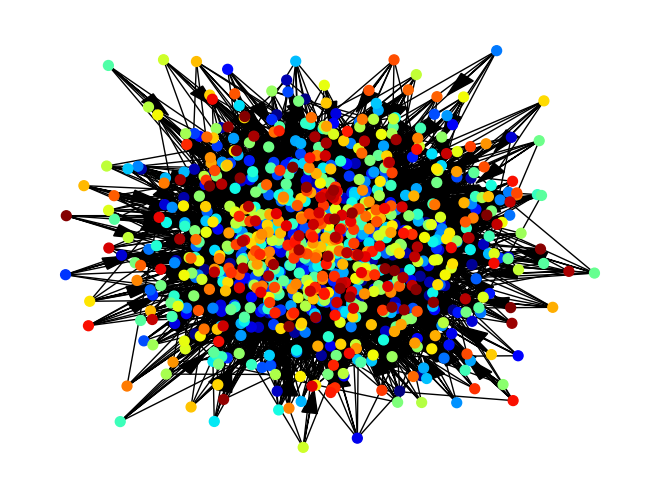

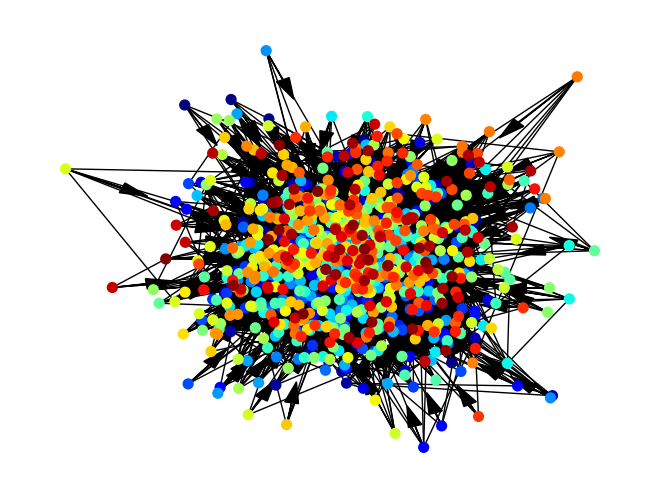

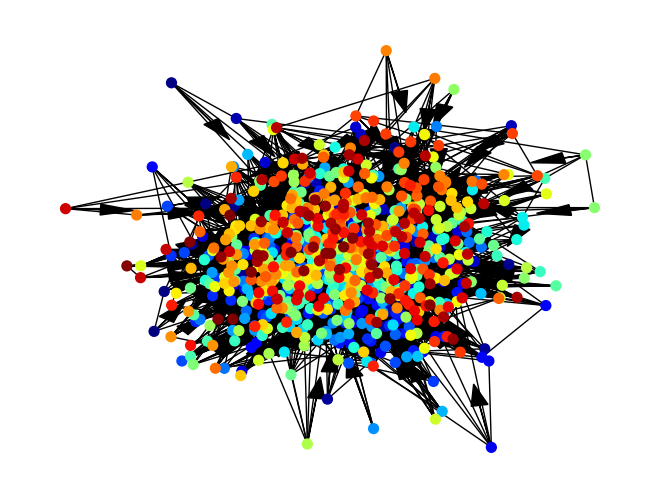

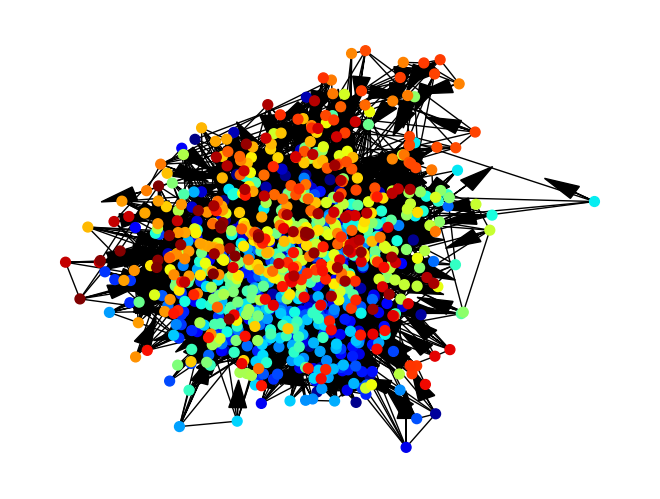

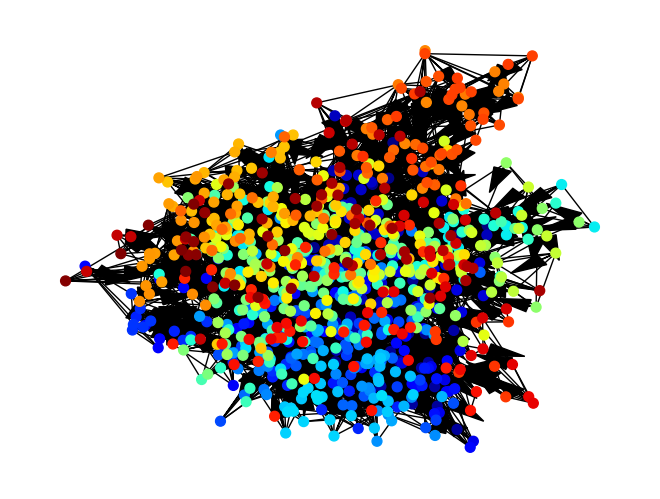

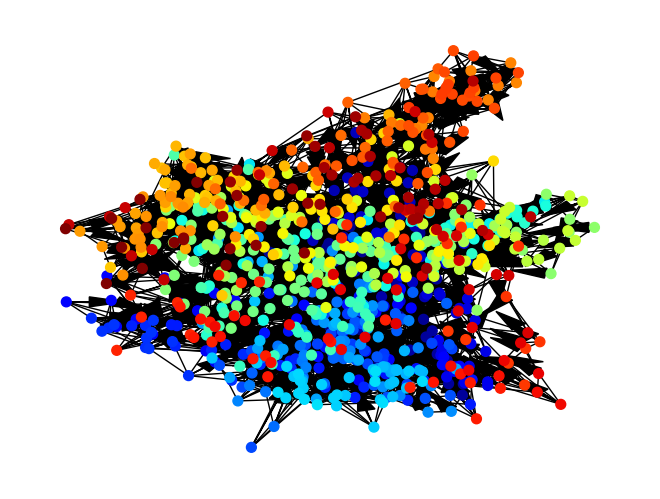

C:\Users\hirok\AppData\Local\Temp\ipykernel_1628\509211456.py:177: LineSearchWarning: The line search algorithm did not converge
  res = line_search(cost_fun, grad_fun, pos[i], -grad)


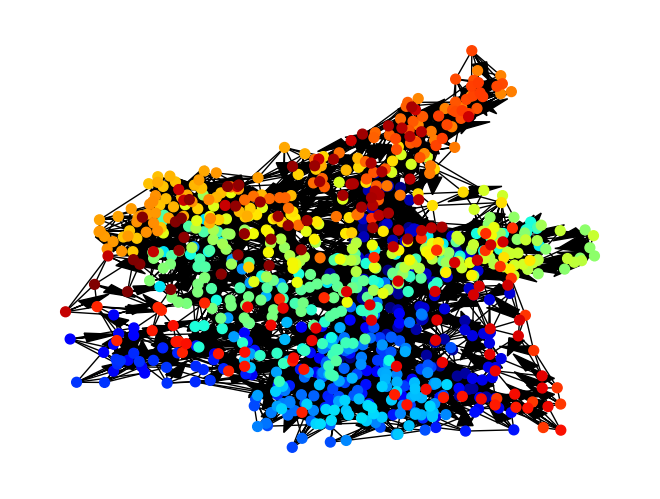

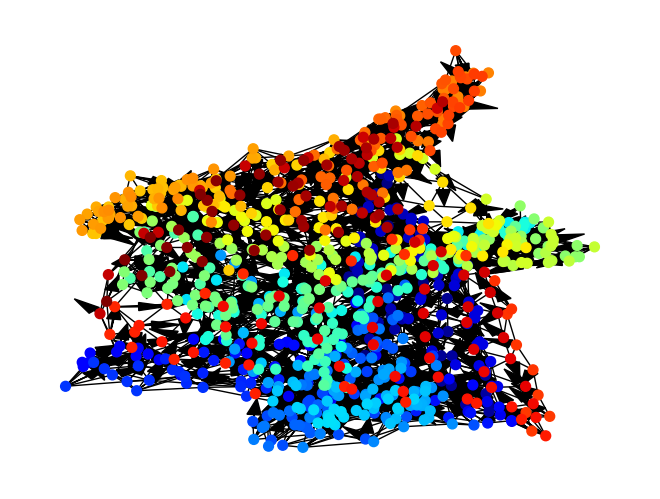

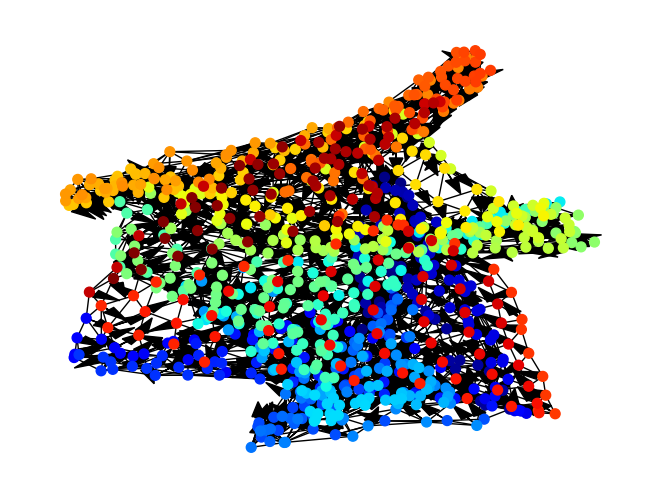

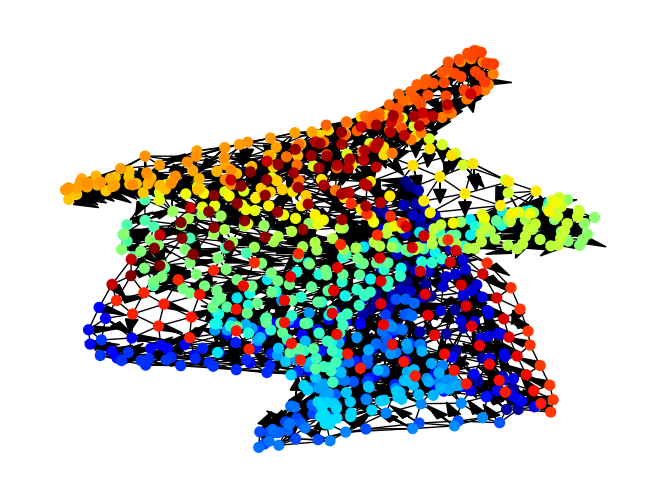

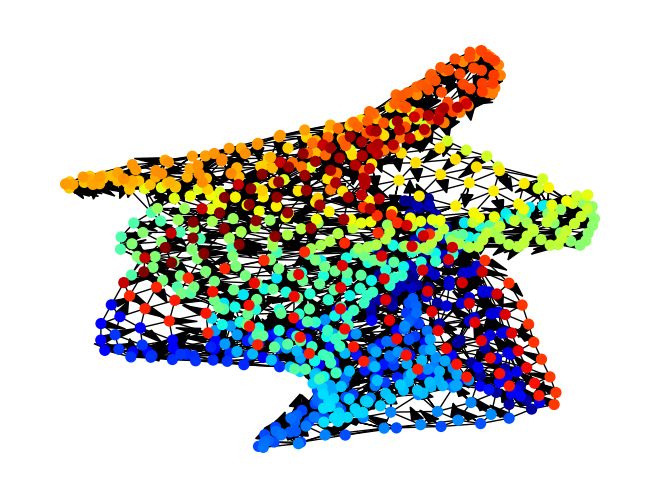

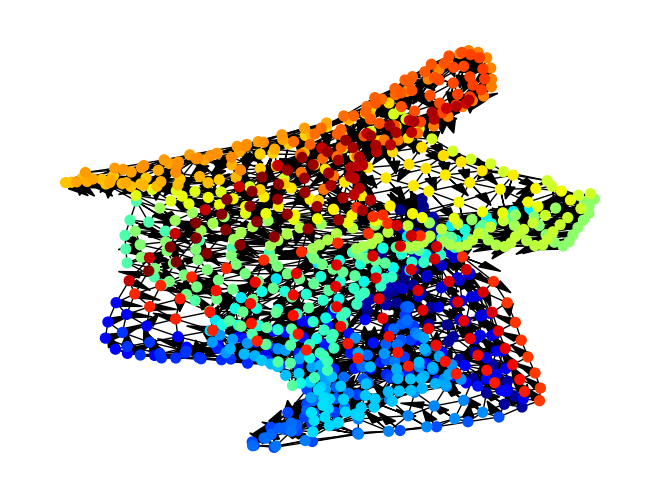

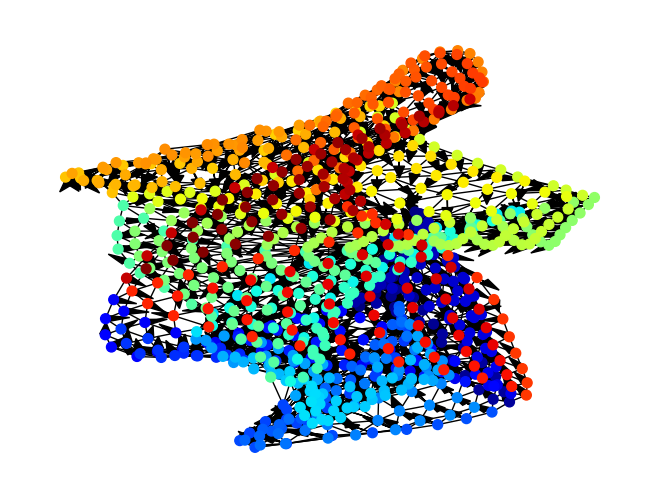

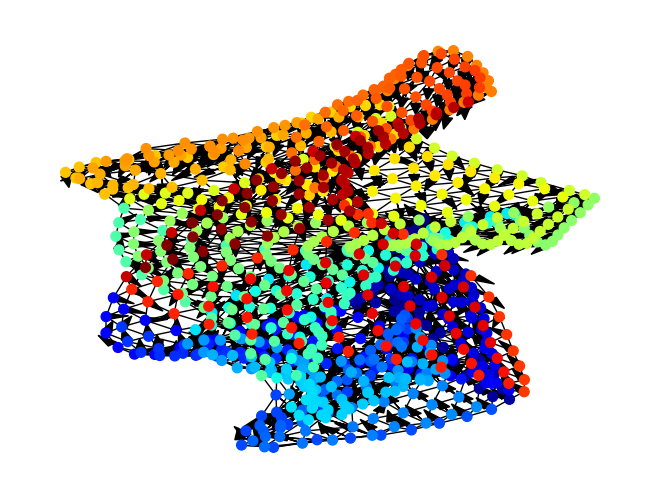

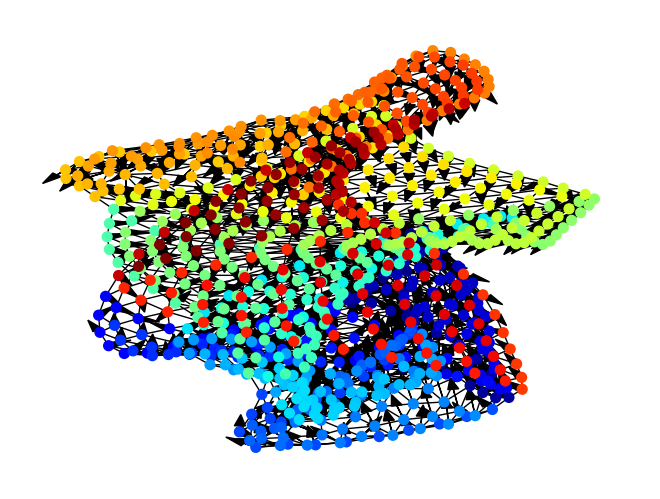

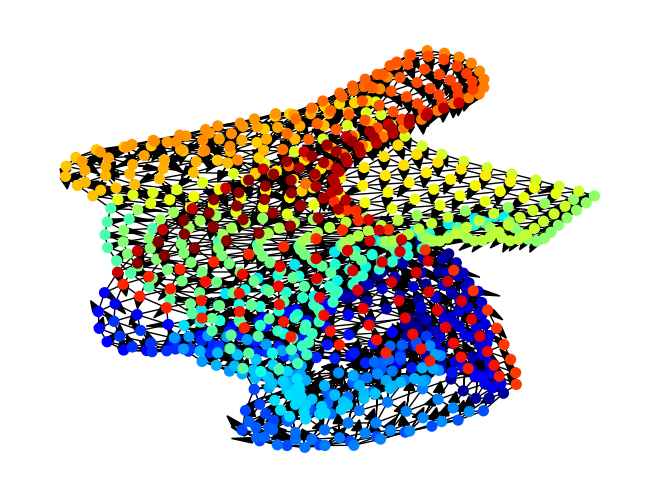

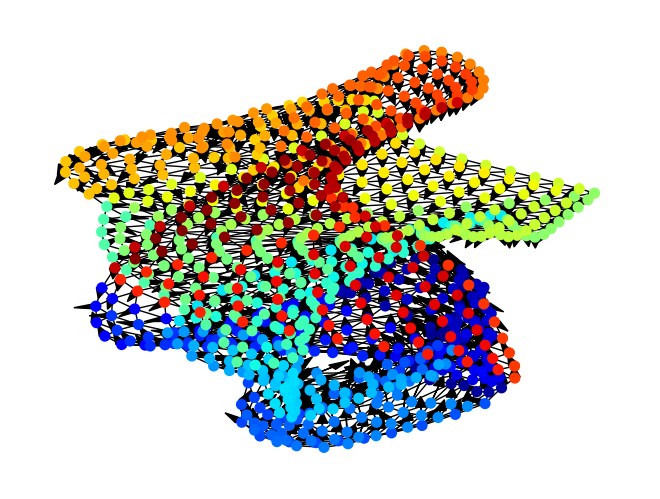

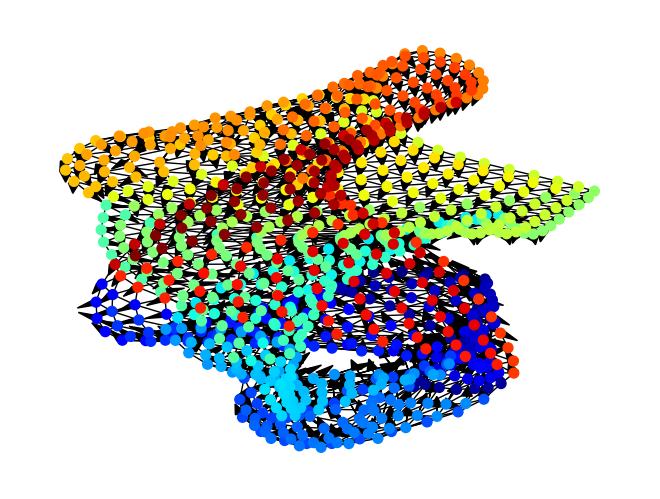

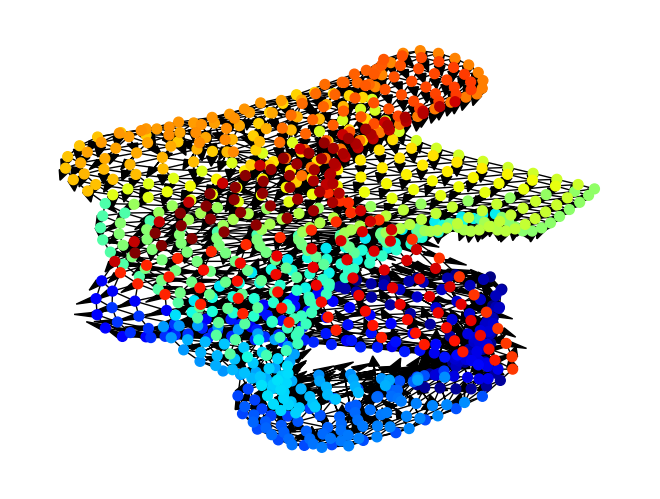

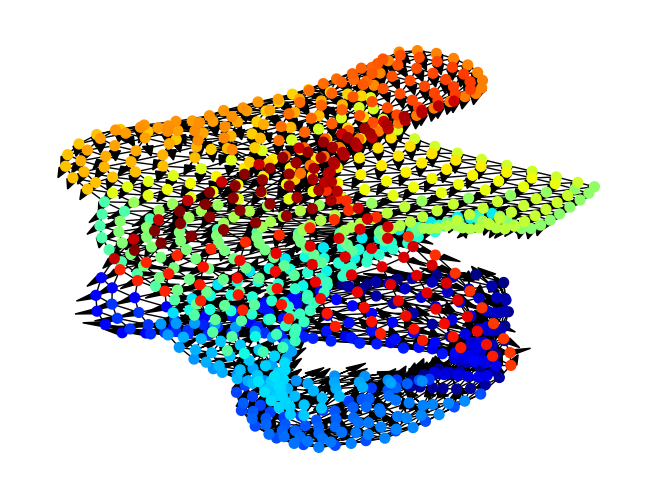

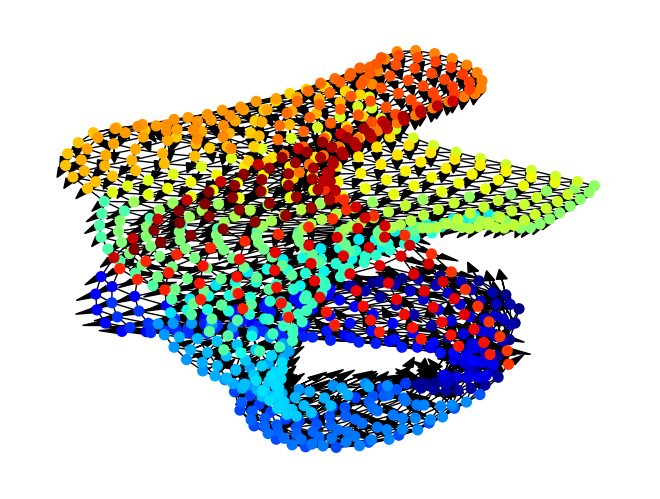

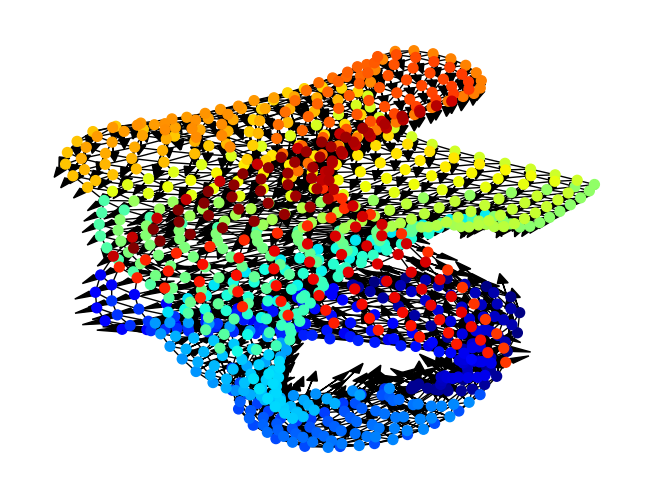

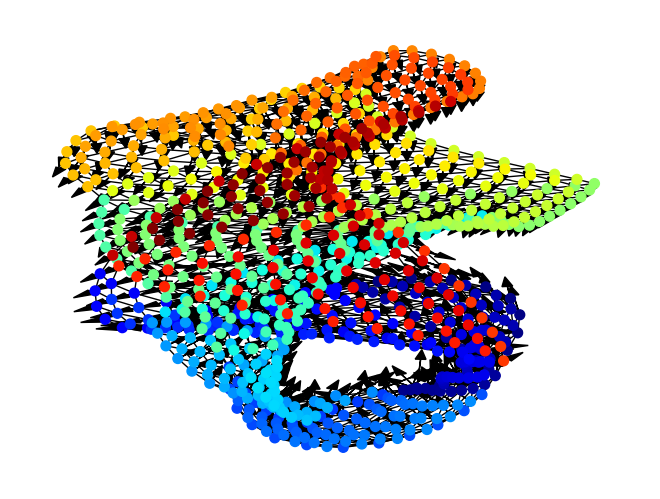

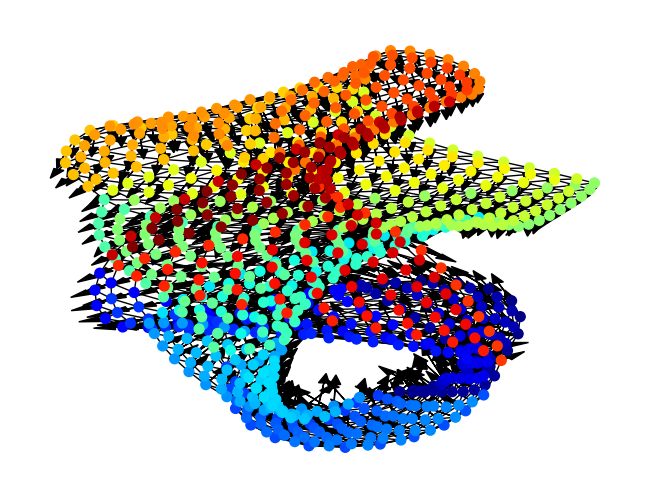

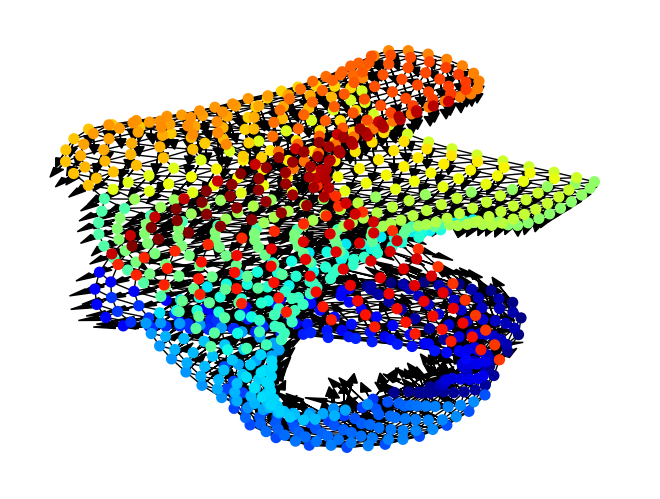

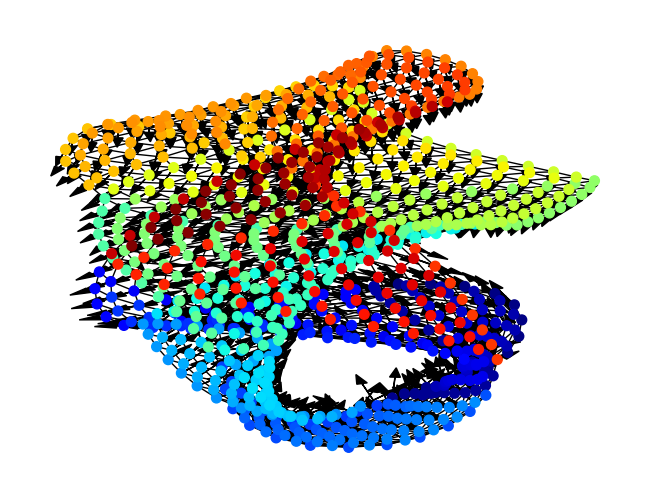

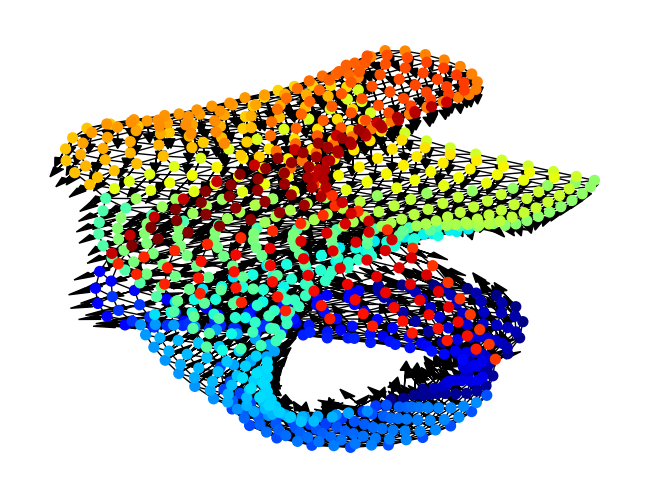

KeyboardInterrupt: 

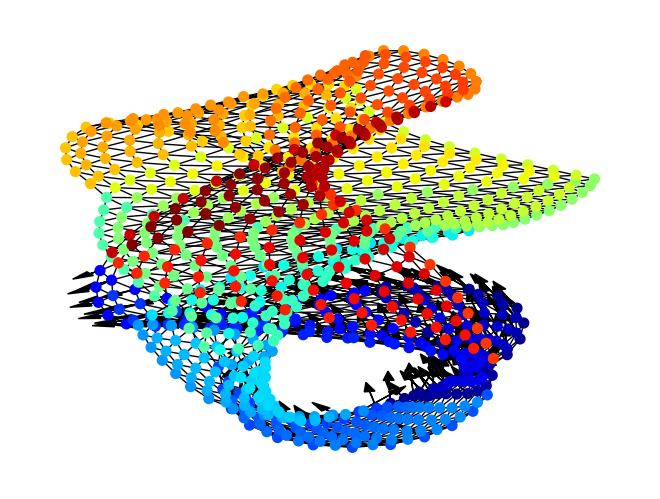

In [16]:
# mat = getMatrixByName("jagmesh1")
n = 20
mat = np.zeros((n, n))
for i in range(n):
    mat[i, (i + 1) % n] = 1
    mat[(i + 1) % n, i] = 1
mat = scipy.sparse.csr_matrix(mat)

if scipy.sparse.issparse(mat):
    mat.setdiag(0)
    mat.eliminate_zeros()
    mat.data = np.abs(mat.data)
else:
    mat[np.diag_indices_from(mat)] = 0
    mat.data = np.abs(mat.data)

G = nx.Graph(mat)


if True:
    for iteration, (pos, grad) in enumerate(
        spring_layout(G, seed=0, method="coordinate_descent", iterations=50)
    ):
        if iteration % 1 == 0:
            visGraph(G, pos, grad)
    # visGraph(G, list(spring_layout(G, method="FR", iterations=250))[-1])
if False:
    import time

    t0 = time.perf_counter()
    # list(spring_layout(G, seed=0, method="L-BFGS-B", iterations=10))
    t1 = time.perf_counter()
    # list(spring_layout(G, seed=0, method="CG", iterations=10))
    t2 = time.perf_counter()
    # list(spring_layout(G, seed=0, method="myCG", iterations=10))
    t3 = time.perf_counter()

    print(f"L-BFGS-B: {t1-t0}[sec]")
    print(f"      CG: {t2-t1}[sec]")
    print(f"    myCG: {t3-t2}[sec]")